# Prompt 
The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

There were only a few duplicated rows and no missing data presented here. The duplicataed rows were not dropped.

This fictional dataset was only for a few months from 1970, with no strange outliers from other times.

The data show steadily increasing log-ins over those few months.

The data showed that Saturday and Sunday were the peak days of the week to sign in. 20% of log-ins happened on 
Saturday, and 19% happened on Sunday, but even distribution throughout the week would only result in 14% of traffic
each day. 

The data also show that the hours surrounding midnight and noon were the most popular log-in times. 
Under an even distribution, each hour would get 4% of the traffic. But the few hours surrounding "12 o clock" have
about 6% of the traffic. 

I would be suspicious of this if I did not know this was simulated, and would want to check for erroneous data dumps
or possibly malicious activity.


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels as sm
import requests
import ydata_profiling
from ydata_profiling.utils.cache import cache_file
from statsmodels.tsa import seasonal

In [2]:
#read in data
logins = pd.read_json('logins.json')
loginsdf = pd.DataFrame(logins)
loginsdf

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
...,...
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38


# Observations from fancy ydata_profiling package

There are no missing rows. 

There are some duplicate rows, just under 1% of the entries. These are all logins for all users, so it's alright
to have duplicates. No need to remove them. 

The data is only for a few months in 1970. There is no strange data that looks like a typo.
It looks like there may be some periodicity by my eye, but I need to examine further. 


In [4]:
profile_report = loginsdf.profile_report(
    explorative=True, html={"style": {"full_width": True}}
)
profile_report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
#Confirm this data is datetime64[ns]
loginsdf.dtypes

login_time    datetime64[ns]
dtype: object

In [18]:
loginsdf

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
...,...
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38


In [21]:
#Great, it's already in the right format. 
#To plot by time more easily, let's make the log-in times the index, and count by 15 minute chunks as 
#requested in the prompt

aggs = loginsdf.copy()
aggs.index = (aggs.login_time) 
#Count the individual log-in times as a new column.
aggs['login'] = 1 
#With datatime data, you can resample with strings to indicate an appropriate time chunk.
#Chop up into fifteen minute chunks and add up the 1s from the login column
aggs = pd.DataFrame(aggs.login.resample('15Min').sum())
#replace NaNs with 0 so we have a smooth timescale
aggs = aggs.fillna(0) 
aggs

#Notice we have reduced ~93k entries to ~10k entries and the intervals are fifteen minutes apart. 
#Success!

,login
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
...,...
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2


Text(0.5, 1.0, 'Seasonality')

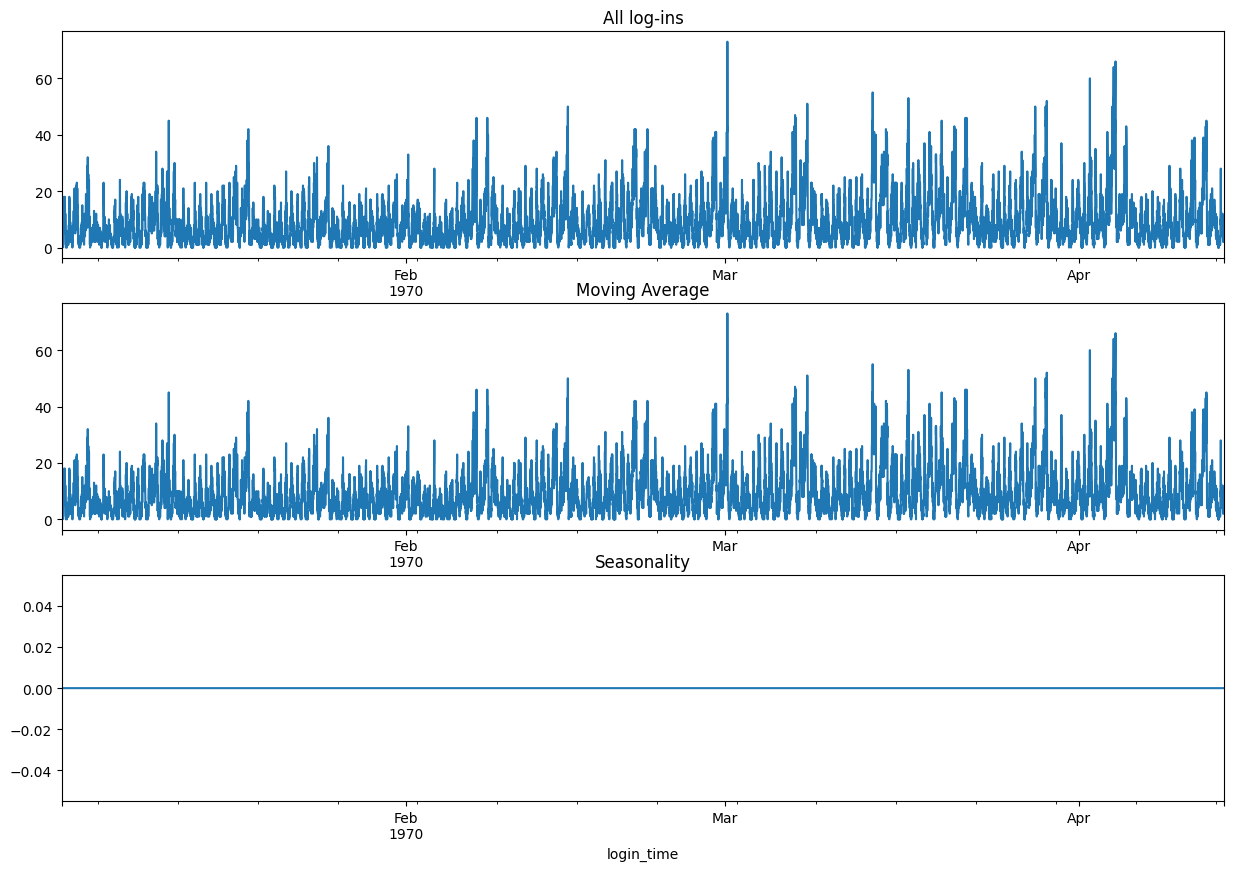

In [25]:
#Let's observe the single fifteen minute increments
#There seems to be a trend intuitively, but it's so noisy no seasonality is shown

plt.figure(figsize=(15,10))
r = sm.tsa.seasonal.seasonal_decompose(aggs.login, model='additive', period = 1)
plt.subplot(3,1,1)
r.observed.plot()
plt.title('All log-ins')
plt.subplot(3,1,2)
r.trend.plot()
plt.title('Moving Average')
plt.subplot(3,1,3)
r.seasonal.plot()
plt.title('Seasonality')

Text(0.5, 1.0, 'Seasonality')

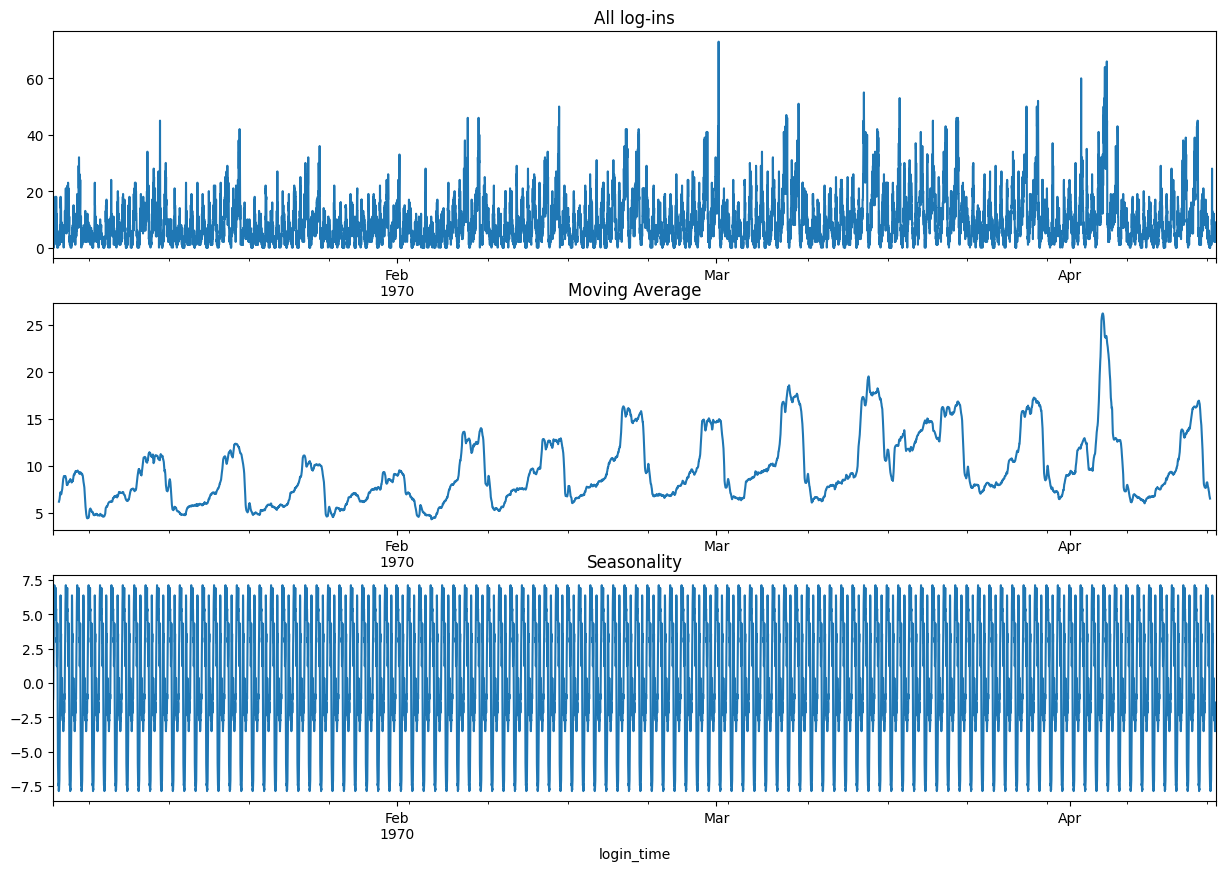

In [26]:
#Let's observe a per-day basis, which is 96 increments
# 24 hours*60 minutes/15 minutes = 96
#Now we can see seasonality better. 
#It looks like there are certain times of the week that people are more likely to log in, which seems sensible.

plt.figure(figsize=(15,10))
r = sm.tsa.seasonal.seasonal_decompose(aggs.login, model='additive', period = 96)
plt.subplot(3,1,1)
r.observed.plot()
plt.title('All log-ins')
plt.subplot(3,1,2)
r.trend.plot()
plt.title('Moving Average')
plt.subplot(3,1,3)
r.seasonal.plot()
plt.title('Seasonality')

Text(0.5, 1.0, 'Seasonality')

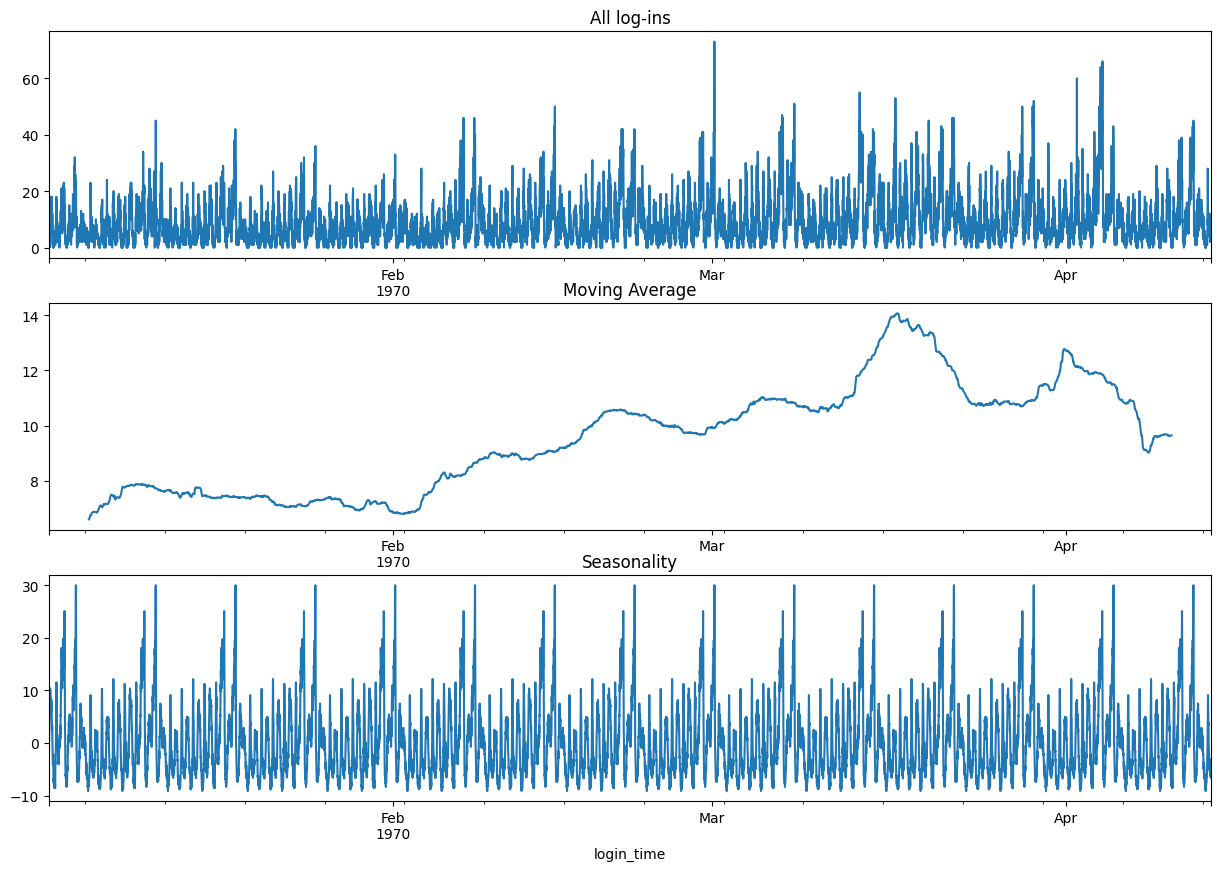

In [27]:
#Let's observe a per-week (7 day) basis, which is 672 increments
# 24 hours*60 minutes*7 days/15 minutes = 672

#Now we see that we have more logins as spring progresses.


plt.figure(figsize=(15,10))
r = sm.tsa.seasonal.seasonal_decompose(aggs.login, model='additive', period = 672)
plt.subplot(3,1,1)
r.observed.plot()
plt.title('All log-ins')
plt.subplot(3,1,2)
r.trend.plot()
plt.title('Moving Average')
plt.subplot(3,1,3)
r.seasonal.plot()
plt.title('Seasonality')

In [53]:
#We see a weekly trend, like there is a specific day of the week which is popular. 
#But it is hard to tell which day and if it is always the same day or if it is rolling, like actually every 8 days

#average each reading by day of week across the whole dataset
daily = aggs.copy()
daily = pd.DataFrame(data = daily.login.groupby(daily.index.dayofweek).mean())

daily

,login
login_time,
0,6.213380
1,6.895833
2,7.692708
3,8.794118
4,10.561111
5,13.456250
6,12.615972


In [55]:
#Checking this doc shows monday is 0 and sunday is 6, so let's address that in a more human way
# https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.dayofweek.html#:~:text=It%20is%20assumed%20the%20week,the%20dt%20accessor)%20or%20DatetimeIndex.&text=Containing%20integers%20indicating%20the%20day%20number.

daily = daily.rename(index={0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday',
                           5: 'Saturday', 6: 'Sunday'})

daily

,login
login_time,
Monday,6.213380
Tuesday,6.895833
Wednesday,7.692708
Thursday,8.794118
Friday,10.561111
Saturday,13.456250
Sunday,12.615972


In [71]:
#Just curious to see the percentages for each day over the whole week
daily["pct"] = daily["login"]/daily["login"].sum()*100
daily

,login,pct
login_time,,
Monday,6.213380,9.381608
Tuesday,6.895833,10.412047
Wednesday,7.692708,11.615252
Thursday,8.794118,13.278274
Friday,10.561111,15.946265
Saturday,13.456250,20.317647
Sunday,12.615972,19.048908


Text(0.5, 1.0, 'Average Log-ins By Day of Week')

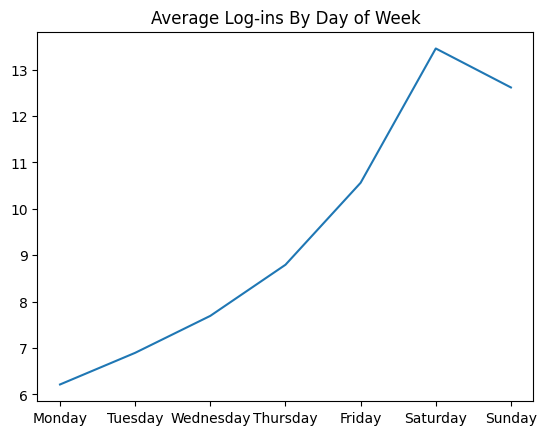

In [56]:
#Here we see that saturday and sunday are the most popular days to log in!
plt.plot(daily.values)
plt.xticks([0,1,2,3,4,5,6], days)
plt.title('Average Log-ins By Day of Week')

Text(0.5, 1.0, 'Average Log-ins By Hour of Day')

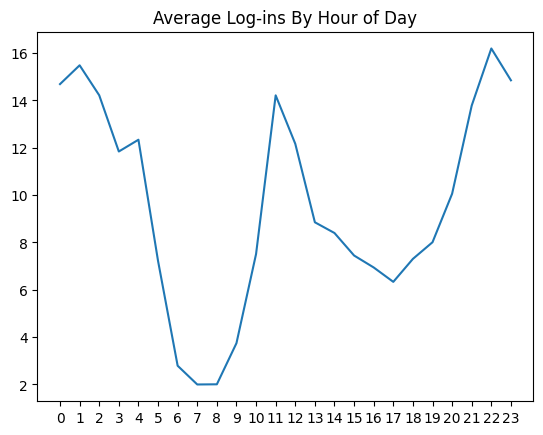

In [66]:
#Furthermore, noon and midnight are the most popular log in times!
#I wonder if this is actually due to a data dump scheduled for those hours? That seems like an odd way
#for people to behave.
#Of course this is simulated data, but if it wasn't I might suspect robot traffic.


#average each reading by hour across the whole dataset
hourly = aggs.copy()
hourly = pd.DataFrame(data = hourly.login.groupby(hourly.index.hour).mean())

#This uses the typical 24 hour clock where 0 is midnight. No need to clarify further, but let's make each hour clear
# on the graph.
hours = list(range(0,24,1))

plt.plot(hourly.values)
plt.xticks(hours)
plt.title('Average Log-ins By Hour of Day')

In [72]:
#Just curious to see the percentages for each hour over the whole day
hourly["pct"] = hourly["login"]/hourly["login"].sum()*100
hourly

,login,pct
login_time,,
0,14.688725,6.432050
1,15.482843,6.779786
2,14.215686,6.224911
3,11.840686,5.184921
4,12.338235,5.402793
5,7.218137,3.160752
6,2.789216,1.221370
7,1.997549,0.874707
8,2.004902,0.877927
